In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, medial_axis
from skimage.filters import gaussian, median
from scipy.ndimage import label
from scipy.signal import convolve2d

In [50]:

class FilFinderPipeline:
    def __init__(self, image):
        self.image = image.mean(axis=2).astype(float) if image.ndim == 3 else image.astype(float) 
        self.params = self._get_default_params()

        # Armazena os resultados intermediários
        self.flattened_image = None
        self.smoothed_image = None
        self.mask = None
        self.skeleton = None
        self.pruned_skeleton = None

    def _get_default_params(self):
        return {
            'gaussian_sigma': 1.0,          # Sigma para suavização Gaussiana
            'adaptive_threshold_size': 40,  # Tamanho do patch para limiar adaptativo
            'min_mask_area': 20,            # Área mínima para um objeto na máscara
            'median_filter_size': 5,        # Tamanho do filtro de mediana para limpar a máscara
            'prune_threshold': 15,          # Limiar de comprimento para poda de ramos
        }

    # A imagem é transformada usando uma função arco-tangente para 
    # suprimir objetos muito brilhantes que poderiam ofuscar os filamentos.

    def flatten_image(self):   # Etapa 1: Achata a imagem usando uma transformação de arco tangente.
        positive_pixels = self.image[self.image > 0]
        if positive_pixels.size == 0:
            self.flattened_image = self.image
            return

        log = np.log(positive_pixels)
        mu = np.mean(log)   # média
        sigma = np.std(log) # desvio padrão
        
        i_0 = np.exp(mu + 2 * sigma)
        self.flattened_image = i_0 * np.arctan(self.image / i_0)
        print("Etapa 1: Imagem achatada com sucesso.")

    # Os dados achatados são suavizados com um filtro Gaussiano para minimizar 
    # variações de pequena escala dentro dos filamentos (0.05 pc), o que ajuda a evitar 
    # a detecção de elementos ruidosos.

    def smooth_image(self): # Etapa 2: Suavizar a imagem achatada com um filtro Gaussiano.
        self.smoothed_image = gaussian(self.flattened_image, sigma=self.params['gaussian_sigma'])
        print("Etapa 2: Imagem suavizada.")

    # Em vez de um único limiar de brilho para toda a imagem, 
    # o algoritmo compara cada pixel com a mediana de uma pequena 
    # área ao seu redor (tamanho do patch de 0.2 pc). Isso permite que filamentos sejam detectados 
    # tanto em regiões brilhantes quanto em regiões mais fracas da imagem.

    # Objetos na máscara com uma área menor que um limiar (5pi(0.1 pc)^2) 
    # são removidos, pois são considerados ruído.

    # Um filtro de mediana final é aplicado para suavizar as bordas dos objetos na máscara, 
    # o que limita a criação de ramificações fake na etapa seguinte.
    
    def create_mask(self): 

        # Etapa 3: Criar máscara com limiar adaptativo.
        footprint = np.ones((self.params['adaptive_threshold_size'], self.params['adaptive_threshold_size']))
        local_median = median(self.smoothed_image, footprint)
        adaptive_mask = self.smoothed_image > local_median

        # Etapa 4: Remover objetos pequenos com área abaixo de um limiar.
        cleaned_mask = remove_small_objects(adaptive_mask, min_size = 5*np.pi*(self.params['min_mask_area'])**2)
        print("Etapas 3 e 4: Máscara adaptativa criada e objetos pequenos removidos.")

        # Etapa 5: Aplicar filtro de mediana para suavizar as bordas da máscara.
        self.mask = median(cleaned_mask, np.ones((self.params['median_filter_size'], self.params['median_filter_size'])))
        print("Etapa 5: Máscara finalizada.")

    # Após a criação da máscara, cada estrutura é reduzida a um esqueleto usando
    # Medial Axis Transform. Contudo, este processo cria muitas pequenas 
    # ramificações indesejadas que precisam ser podadas.

    def skeletonize(self):  # Etapa 6: Esqueletização usando a Medial Axis Transform.
        self.skeleton = medial_axis(self.mask)
        print("Etapa 6: Esqueletização concluída.")

    def prune_skeleton(self):  # Etapa 7: Poda do esqueleto para remover ramificações curtas.

        kernel = np.ones((3, 3), dtype=np.uint8)
        neighbors = convolve2d(self.skeleton, kernel, mode='same') * self.skeleton
        endpoints = (neighbors == 2) # (1 para o próprio pixel, 1 para o vizinho)
        
        labeled_skeleton, num_branches = label(self.skeleton)
        
        pruned_skeleton = self.skeleton.copy()
        
        for i in range(1, num_branches + 1):
            branch_pixels = np.argwhere(labeled_skeleton == i)
   
            if len(branch_pixels) < self.params['prune_threshold']:
                is_endpoint_branch = False
                for y, x in branch_pixels:
                    if endpoints[y, x]: # Verifica se este ramo caba ou se conecta novamente
                        is_endpoint_branch = True
                        break
                
                if is_endpoint_branch:
                    for y, x in branch_pixels:
                        pruned_skeleton[y, x] = 0
        
        self.pruned_skeleton = pruned_skeleton
        print("Etapa 7: Poda do esqueleto concluída.")

    def run_pipeline(self):
        self.flatten_image()
        self.smooth_image()
        self.create_mask()
        self.skeletonize()
        self.prune_skeleton()
        print("\nPipeline FILFINDER concluída.")

    def plot_results(self):
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        ax = axes.ravel()

        ax[0].imshow(self.image, cmap='gray', origin='lower')
        ax[0].set_title('Imagem Original')

        ax[1].imshow(self.flattened_image, cmap='gray', origin='lower')
        ax[1].set_title('1. Imagem Achatada')

        ax[2].imshow(self.smoothed_image, cmap='gray', origin='lower')
        ax[2].set_title('2. Imagem Suavizada')

        ax[3].imshow(self.mask, cmap='gray', origin='lower')
        ax[3].set_title('3-5. Máscara Final')

        ax[4].imshow(self.skeleton, cmap='gray', origin='lower')
        ax[4].set_title('6. Esqueleto')
        
        ax[5].imshow(self.pruned_skeleton, cmap='gray', origin='lower')
        ax[5].set_title('7. Esqueleto Podado')
        
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        plt.tight_layout()
        plt.show()

        pruned_mask = np.ma.masked_where(self.pruned_skeleton == 0, self.pruned_skeleton)
        
        plt.imshow(self.image, cmap='gray', origin='lower')
        plt.imshow(pruned_mask, cmap='OrRd', vmin=0, vmax=1, origin='lower')
        plt.title('Filamento sobre a Imagem ')

        plt.show()

Etapa 1: Imagem achatada com sucesso.
Etapa 2: Imagem suavizada.
Etapas 3 e 4: Máscara adaptativa criada e objetos pequenos removidos.
Etapa 5: Máscara finalizada.
Etapa 6: Esqueletização concluída.
Etapa 7: Poda do esqueleto concluída.

Pipeline FILFINDER concluída.


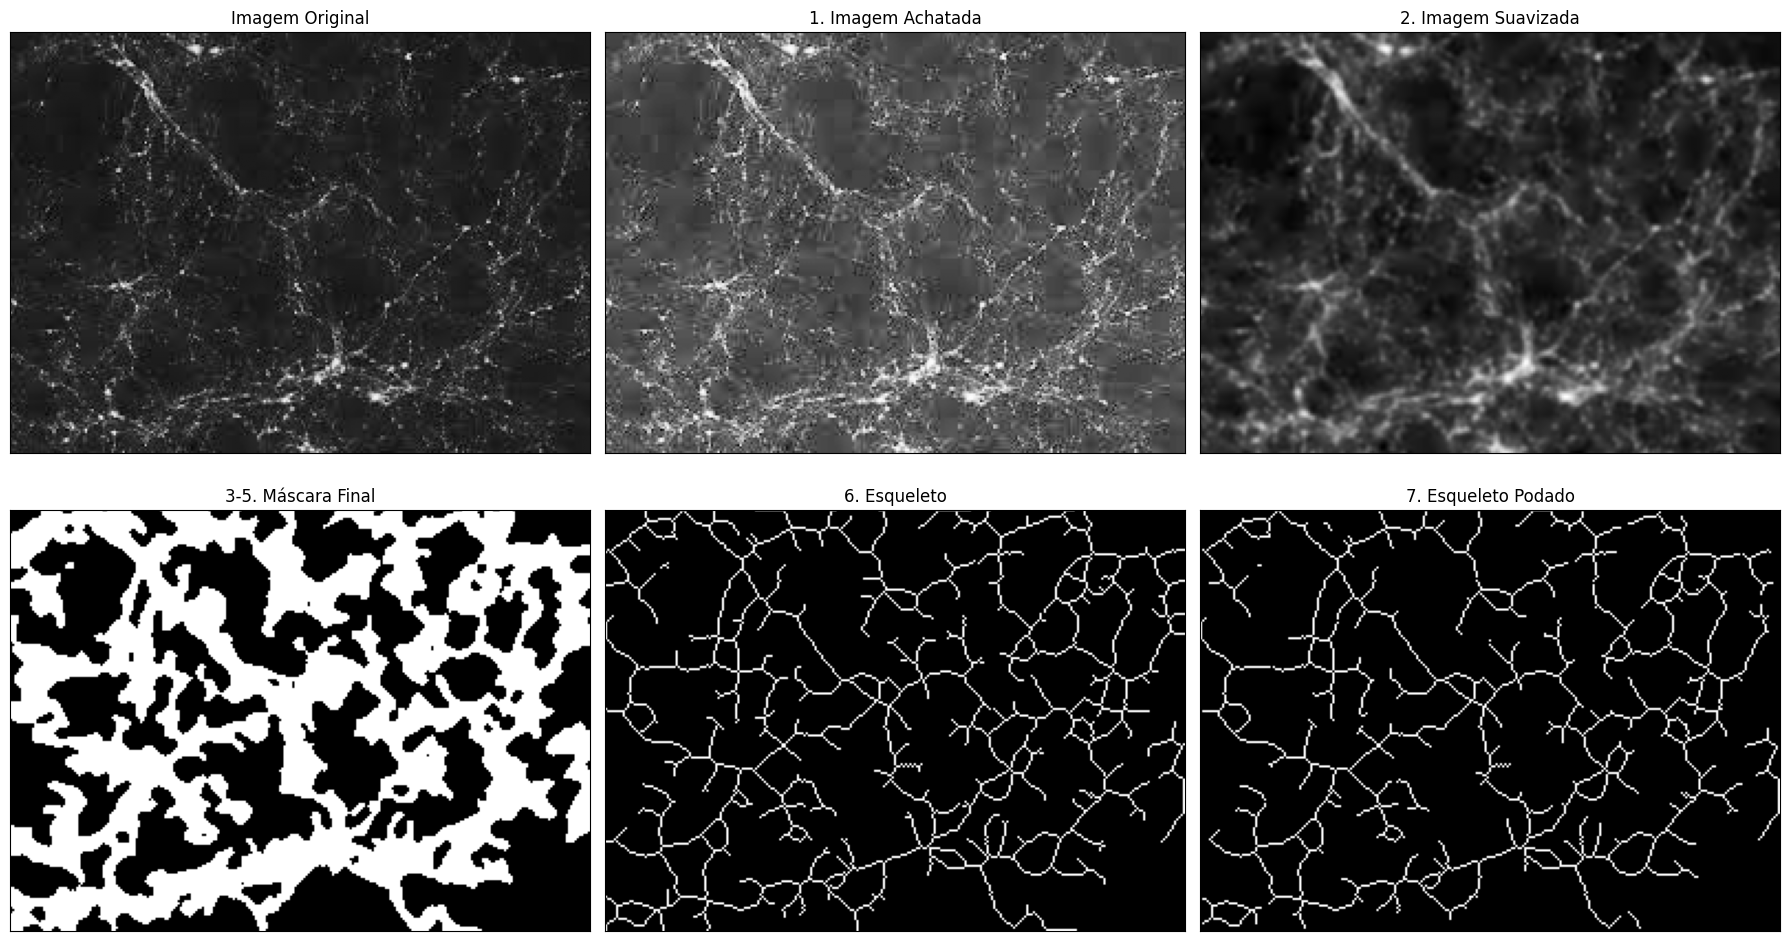

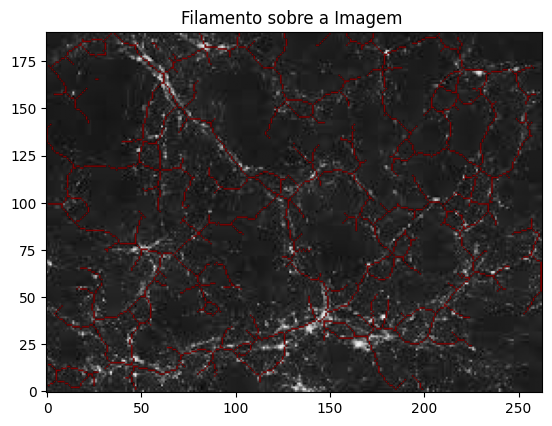

In [51]:
img = plt.imread('image.jpeg')

# Instancia e executa a pipeline
filfinder = FilFinderPipeline(img)
filfinder.run_pipeline()

# Mostra os resultados
filfinder.plot_results()

Etapa 1: Imagem achatada com sucesso.
Etapa 2: Imagem suavizada.
Etapas 3 e 4: Máscara adaptativa criada e objetos pequenos removidos.
Etapa 5: Máscara finalizada.
Etapa 6: Esqueletização concluída.
Etapa 7: Poda do esqueleto concluída.

Pipeline FILFINDER concluída.


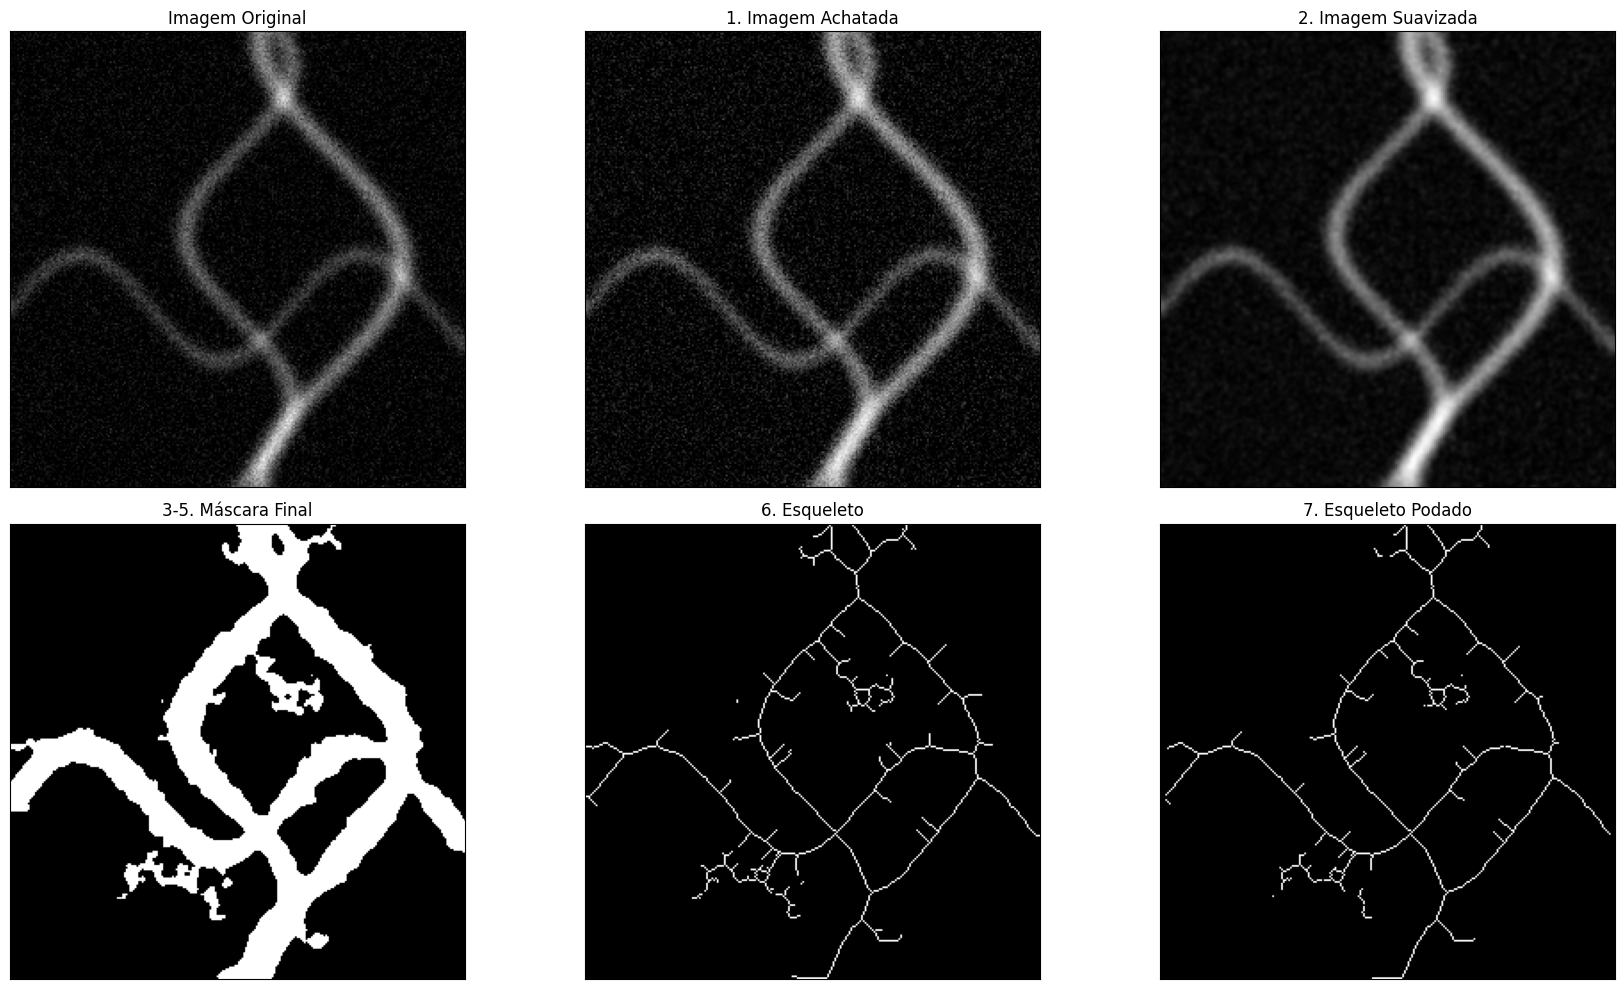

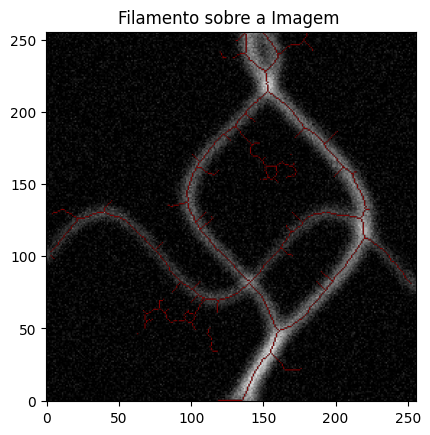

In [52]:
np.random.seed(42)
shape = (256, 256)
x, y = np.indices(shape)

# Cria algumas estruturas sinusoidais para simular filamentos
filament1 = 0.8 * np.exp(-((y - 128 - 30 * np.sin(x / 30.0))**2) / 20)
filament2 = 1.0 * np.exp(-((y - 180 + 40 * np.cos(x / 40.0))**2) / 30)
filament3 = 0.6 * np.exp(-((x - 100 - 30 * np.sin(y / 25.0))**2) / 15)

synthetic_image = filament1 + filament2 + filament3
synthetic_image = gaussian(synthetic_image, sigma=3)

# Adiciona ruído Gaussiano
noise = 0.1 * np.random.randn(*shape)
synthetic_image += noise
synthetic_image = np.clip(synthetic_image, 0, np.max(synthetic_image))

filfinder = FilFinderPipeline(synthetic_image)
filfinder.run_pipeline()

# Mostra os resultados
filfinder.plot_results()